Milestone2


In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np

#upload kaggle.json for api access
# from google.colab import files
# files.upload()

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json


Dataset available at: https://www.kaggle.com/datasets/tonygordonjr/football-match-statistics-and-more/data?fbclid=IwZXh0bgNhZW0CMTEAAR27HPyyqC9nUioeOqJzVzznFoIH3SNY0xcdZ_4dDxEpDOoRnZgcaXdTTRE_aem_0dX5wF1-vk6WmlQWZMnQ2g

In [ ]:
# !kaggle datasets download -d tonygordonjr/football-match-statistics-and-more
# !unzip /content/football-match-statistics-and-more.zip -d ./

In [ ]:
teams_clean_col = ['fixture_id', 'team_id', 'team_name', 'fouls','yellow_cards', 'red_cards']
stats_clean_col = ['fixture_id', 'fixture_date', 'fixture_referee', 'league_id', 'league_name', 'teams_home_id', 'teams_home_name', 'teams_away_id', 'teams_away_name']
players_clean_col = ['fixture_id', 'team_id', 'team_name', 'player_id', 'player_name', 'fouls_committed', 'yellow_cards', 'red_cards', 'game_minutes']

fix_teams_clean = pd.read_csv("fixture_stats_teams_clean.csv",usecols=teams_clean_col)
fix_clean = pd.read_csv("fixture_stats_clean.csv", usecols=stats_clean_col)
fix_players_clean = pd.read_csv("fixture_stats_players_clean.csv",usecols=players_clean_col)

In [ ]:
# team ids are actual identifiers (not like player_ids)
fix_teams_clean.groupby(['team_id', 'team_name']).size().reset_index().team_name.value_counts()

,count
team_name,
Bay FC,1
Belgium,1
France,1
Robin Hood,1
Al Riyadh,1
...,...
Colombia,1
Uruguay,1
Brazil,1


In [ ]:
# fixture_date added to the players statistics for further data preparation purposes: fix_players_clean
fix_players_clean = fix_players_clean.merge(fix_clean[['fixture_id', 'fixture_date']], on='fixture_id', how='left')
# fix_players_clean = fix_players_clean_og.copy()

A run_mode beállításával lehet meghatározni a célváltozót: total=fogadóirodák által számolt lapérték. yellow=csak sárga. red=csak piros. Az adatelőkészítés végén kimentődik a megfelelő dataframe-be (yellow_final, total_final, red_final), és a tanítás előtt is lehet run_mode-ot állítani, és az meg a megfelelő célváltozójú, előfeldogozott adatsetet (yellow_final, total_final, red_final) tölti be és arra épít modellt, ha az létezik.

In [ ]:
# Összes kapott lap kiszámítása minden játékosra: fix_players_clean
run_mode = 'yellow' #(total, yellow, red)
if run_mode == 'total':
  fix_players_clean['total_cards'] = fix_players_clean.apply(lambda x: x['yellow_cards'] + x['red_cards'] * 2 if x['yellow_cards'] != 2 else 3, axis=1)
elif run_mode == 'yellow':
  fix_players_clean['total_cards'] = fix_players_clean['yellow_cards']
elif run_mode == 'red':
  fix_players_clean['total_cards'] = fix_players_clean['red_cards']
else:
  raise ValueError("Invalid run_mode. Must be 'total', 'yellow', or 'red'.")
fix_players_clean.drop(['yellow_cards', 'red_cards'], axis=1, inplace=True)

In [ ]:
# Összes kapott lap kiszámítása minden játékosra: fix_players_clean
#fix_players_clean['total_cards'] = fix_players_clean.apply(lambda x: x['yellow_cards'] + x['red_cards'] * 2 if x['yellow_cards'] != 2 else 3, axis=1)
# fix_players_clean.sort_values('red_cards', ascending=False).head()

#fix_players_clean.drop(['yellow_cards', 'red_cards'], axis=1, inplace=True)

In [ ]:
# Játékosok kidobása ha game_minutes isna: fix_players_clean
# Ezek a pályán kívül kapott lapok amik nem számítanak bele az összes lap számába a fogadóirodáknál
# fix_players_clean[(fix_players_clean['game_minutes'].isna()) & (fix_players_clean['total_cards'] != 0)].sort_values(by=['total_cards', 'fixture_date'], ascending=[False, False])

fix_players_clean.drop(fix_players_clean[fix_players_clean["game_minutes"].isna()].index, inplace=True)
fix_players_clean["game_minutes"].isna().sum()

np.int64(0)

In [ ]:
# Összes kapott lap kiszámításra minden csapatra minden meccsen: fix_total_cards
fix_total_cards = fix_players_clean.groupby(['fixture_id', 'team_id'])['total_cards'].sum().reset_index()
fix_total_cards = fix_total_cards.merge(fix_clean[['fixture_id', 'fixture_date']], on='fixture_id', how='left')

In [ ]:
fix_total_cards

,fixture_id,team_id,total_cards,fixture_date
0,65,33,2,2018-08-10 19:00:00 UTC
1,65,46,1,2018-08-10 19:00:00 UTC
2,66,34,2,2018-08-11 11:30:00 UTC
3,66,47,2,2018-08-11 11:30:00 UTC
4,67,35,1,2018-08-11 14:00:00 UTC
...,...,...,...,...
64871,1316662,1602,2,2024-12-01 00:30:00 UTC
64872,1316663,1595,4,2024-12-01 03:00:00 UTC
64873,1316663,1605,0,2024-12-01 03:00:00 UTC
64874,1318600,1602,2,2024-12-07 21:00:00 UTC


In [ ]:
# Sort by team and fixture_date to ensure past matches come first
fix_total_cards = fix_total_cards.sort_values(by=["team_id", "fixture_date"])

# Compute past average total cards for each team
fix_total_cards["avg_total_cards"] = (
    fix_total_cards.groupby("team_id")["total_cards"]
    .expanding()
    .mean()
    .shift()  # Shift to exclude current row from the average
    .reset_index(level=0, drop=True)
)

# Minden csapat legkorábbi meccsét dropoljuk, mert az avg_total_cards értéke ott nem megállapítható
fix_total_cards = fix_total_cards.drop(fix_total_cards.groupby('team_id')['fixture_date'].idxmin())

In [ ]:
# Meccsek adataihoz hozzá adjuk a csapatok átlagos kártyáit: fix_total_cards (és cards_tmp)
# Hazai hozzáadása
cards_tmp = fix_clean.merge(fix_total_cards.drop("fixture_date", axis=1), on="fixture_id", how="inner")
cards_tmp = cards_tmp[cards_tmp["team_id"] == cards_tmp["teams_home_id"]]
cards_tmp = cards_tmp.rename(columns={"total_cards": "home_total_cards_value", "avg_total_cards": "avg_home_total_cards"})
cards_tmp = cards_tmp.drop(columns=["team_id"])

# Vendég kártyáinak hozzáadása
cards_tmp = cards_tmp.merge(fix_total_cards.drop("fixture_date", axis=1), on="fixture_id", how="inner")
cards_tmp = cards_tmp[cards_tmp["team_id"] == cards_tmp["teams_away_id"]]
cards_tmp = cards_tmp.rename(columns={"total_cards": "away_total_cards_value", "avg_total_cards": "avg_away_total_cards"})
cards_tmp = cards_tmp.drop(columns=["team_id"])

cards_tmp["total_cards_value"] = cards_tmp["home_total_cards_value"] + cards_tmp["away_total_cards_value"]

fix_total_cards = cards_tmp[['fixture_id', 'fixture_referee', 'fixture_date', 'home_total_cards_value', 'avg_home_total_cards', 'away_total_cards_value', 'avg_away_total_cards', 'total_cards_value']]

In [ ]:
fix_total_cards

,fixture_id,fixture_referee,fixture_date,home_total_cards_value,avg_home_total_cards,away_total_cards_value,avg_away_total_cards,total_cards_value
0,566789,"Felix Brych, Germany",2020-07-06 18:30:00 UTC,2,2.000000,2,2.035088,4
3,9822,"Alfonso Alvarez Izquierdo, Spain",2017-10-01 10:00:00 UTC,3,2.535714,3,2.756098,6
5,203592,"Alberto Undiano, Spain",2016-02-27 21:05:00 UTC,4,3.000000,5,3.000000,9
7,203530,"Juan Martinez Munuera, Spain",2016-01-16 21:05:00 UTC,1,3.263158,3,2.578947,4
9,27416,"Adrian Cordero Vega, Spain",2019-03-15 20:00:00 UTC,2,2.238095,2,3.165049,4
...,...,...,...,...,...,...,...,...
64223,132923,O. Hațegan,2019-10-11 18:45:00 UTC,3,2.000000,5,2.555556,8
64225,1299137,"Benoît Bastien, France",2024-09-26 16:45:00 UTC,4,2.666667,2,2.000000,6
64226,350229,"Jonas Eriksson, Sweden",2016-09-29 19:05:00 UTC,2,2.727273,3,1.000000,5
64228,971763,I. Peljto,2023-02-16 17:45:00 UTC,3,2.000000,3,1.807818,6


In [ ]:
# Sort by referee and fixture_date to ensure past matches come first
fix_total_cards = fix_total_cards.sort_values(by=["fixture_referee", "fixture_date"])

# Compute past average total cards for each referee
fix_total_cards["avg_referee_cards"] = (
    fix_total_cards.groupby("fixture_referee")["total_cards_value"]
    .expanding()
    .mean()
    .shift()  # Shift to exclude current row from the average
    .reset_index(level=0, drop=True)
)

# Minden referee legkorábbi meccsét dropoljuk, mert az avg_referee_cards értéke ott nem megállapítható
fix_total_cards = fix_total_cards.drop(fix_total_cards.groupby('fixture_referee')['fixture_date'].idxmin())

In [ ]:
fix_total_cards

,fixture_id,fixture_referee,fixture_date,home_total_cards_value,avg_home_total_cards,away_total_cards_value,avg_away_total_cards,total_cards_value,avg_referee_cards
22807,164203,A. Woolmer,2019-08-17 14:00:00 UTC,2,2.000000,1,1.871166,3,3.0
46230,164233,A. Woolmer,2019-08-25 11:00:00 UTC,1,1.335366,5,1.858696,6,3.0
1024,164245,A. Woolmer,2019-08-31 14:00:00 UTC,1,1.989691,5,1.680412,6,4.0
2534,164259,A. Woolmer,2019-09-21 14:00:00 UTC,1,1.623656,2,1.622754,3,4.5
24503,164287,A. Woolmer,2019-10-01 19:00:00 UTC,3,1.784211,0,1.802198,3,4.2
...,...,...,...,...,...,...,...,...,...
32556,657877,NaN,2021-05-30 18:00:00 UTC,2,2.068966,2,1.938776,4,NaN
32574,657882,NaN,2021-05-30 18:00:00 UTC,4,1.832000,5,2.007874,9,NaN
50921,657881,NaN,2021-05-30 18:00:00 UTC,3,1.674603,1,2.064000,4,NaN
56631,657879,NaN,2021-05-30 18:00:00 UTC,1,2.110236,3,2.342593,4,NaN


In [ ]:
fix_total_cards.drop(fix_total_cards[fix_total_cards["fixture_referee"].isna()].index, inplace=True)

In [ ]:
# Összes falt kiszámítása minden csapatra meccsenként: fix_total_fouls
fix_total_fouls = fix_teams_clean[["fixture_id", "team_id", "fouls"]]
fix_total_fouls.drop(fix_total_fouls[fix_total_fouls["fouls"] == 0].index, inplace=True)
fix_total_fouls = fix_total_fouls.merge(fix_clean[['fixture_id', 'fixture_date']], on='fixture_id', how='inner')

<ipython-input-21-56908aa801fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fix_total_fouls.drop(fix_total_fouls[fix_total_fouls["fouls"] == 0].index, inplace=True)


In [ ]:
# Sort by team and fixture_date to ensure past matches come first
fix_total_fouls = fix_total_fouls.sort_values(by=["team_id", "fixture_date"])

# Compute past average total cards for each team
fix_total_fouls["avg_total_fouls"] = (
    fix_total_fouls.groupby("team_id")["fouls"]
    .expanding()
    .mean()
    .shift()  # Shift to exclude current row from the average
    .reset_index(level=0, drop=True)
)

# Minden csapat legkorábbi meccsét dropoljk, mert az avg_total_fouls értéke ott nem megállapítható
fix_total_fouls = fix_total_fouls.drop(fix_total_fouls.groupby('team_id')['fixture_date'].idxmin())

In [ ]:
fix_total_fouls.sort_values(by=["team_id", "fixture_date"]).head(10)

,fixture_id,team_id,fouls,fixture_date,avg_total_fouls
50307,152605,1,8,2016-06-18 13:00:00 UTC,10.000000
17785,152619,1,14,2016-06-22 19:00:00 UTC,9.000000
56292,152574,1,10,2016-06-26 19:00:00 UTC,10.666667
17780,152578,1,8,2016-07-01 19:00:00 UTC,10.500000
50310,135789,1,17,2018-06-18 15:00:00 UTC,10.000000
58602,135803,1,12,2018-06-23 12:00:00 UTC,11.166667
17781,135823,1,14,2018-06-28 18:00:00 UTC,11.285714
50312,135766,1,13,2018-07-02 18:00:00 UTC,11.625000
17783,135770,1,16,2018-07-06 18:00:00 UTC,11.777778
323,135773,1,16,2018-07-10 18:00:00 UTC,12.200000


In [ ]:
# Fölösleges oszlopok elhagyása
fix_total_fouls = fix_total_fouls[['fixture_id', 'team_id', 'avg_total_fouls']]

In [ ]:
def calculate_avg_cards_per_90(df):
    # Sort by fixture_id to ensure chronological order
    df = df.sort_values(by=['player_name', 'fixture_date'])

    # Create new columns for storing cumulative stats
    df['cumulative_cards'] = 0
    df['cumulative_fouls'] = 0
    df['cumulative_minutes'] = 0
    df['avg_cards_per_90'] = 0.0
    df['avg_fouls_per_90'] = 0.0

    # Group by player_name and iterate to compute averages from past matches
    grouped = df.groupby('player_name')

    for player_name, player_df in grouped:
        cumulative_cards = 0
        cumulative_fouls = 0
        cumulative_minutes = 0

        for idx, row in player_df.iterrows():
            # Compute averages from past matches
            if cumulative_minutes > 90:
                avg_cards = (cumulative_cards / cumulative_minutes) * 90
                avg_fouls = (cumulative_fouls / cumulative_minutes) * 90
            else:
                avg_cards = 0
                avg_fouls = 0

            # Store calculated averages
            df.at[idx, 'avg_cards_per_90'] = avg_cards
            df.at[idx, 'avg_fouls_per_90'] = avg_fouls

            # Update cumulative stats
            cumulative_cards += row['total_cards']
            cumulative_fouls += row['fouls_committed']
            cumulative_minutes += row['game_minutes']

    return df

In [ ]:
# Játékosok átlagos lap- és falt-számának meghatározás: fix_players_clean
fix_players_clean = calculate_avg_cards_per_90(fix_players_clean)

In [ ]:
# keep only the 22 most played players for all the fixtures
fix_players_clean_22 = fix_players_clean.groupby('fixture_id').apply(lambda x: x.nlargest(22, 'game_minutes')).reset_index(drop=True)

<ipython-input-27-c61ca3a11dfc>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fix_players_clean_22 = fix_players_clean.groupby('fixture_id').apply(lambda x: x.nlargest(22, 'game_minutes')).reset_index(drop=True)


In [ ]:
# Négy topliga kiszűrése: fix_player_topleagues, fix_player_topleagues22
top_leagues = ["La Liga", "Serie A", "Bundesliga", "Premier League"]
fix_clean = fix_clean[fix_clean["league_name"].isin(top_leagues)]

teams_to_keep = list(set(list(fix_clean.teams_home_name.unique())+list(fix_clean.teams_away_name.unique())))

print(len(fix_players_clean))
fix_player_topleagues = fix_players_clean[fix_players_clean['team_name'].isin(teams_to_keep)]
fix_player_topleagues22 = fix_players_clean_22[fix_players_clean_22['team_name'].isin(teams_to_keep)]
print(len(fix_player_topleagues))

939559
521221


In [ ]:
fix_player_topleagues

,fixture_id,team_id,team_name,player_id,player_name,game_minutes,fouls_committed,fixture_date,total_cards,cumulative_cards,cumulative_fouls,cumulative_minutes,avg_cards_per_90,avg_fouls_per_90
614743,665,63,Leeds,19123,Aapo Halme,64.0,0,2018-11-24 15:00:00 UTC,0,0,0,0,0.000000,0.000000
115882,683,63,Leeds,19123,Aapo Halme,69.0,2,2018-12-01 12:30:00 UTC,1,0,0,0,0.000000,0.000000
443871,687,63,Leeds,19123,Aapo Halme,9.0,1,2018-12-08 15:00:00 UTC,0,0,0,0,0.676692,1.353383
886743,699,63,Leeds,19123,Aapo Halme,1.0,0,2018-12-15 15:00:00 UTC,0,0,0,0,0.633803,1.901408
48254,1223613,503,Torino,343538,Aaron Ciammaglichella,1.0,0,2024-08-25 16:30:00 UTC,0,0,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049208,1216075,76,Swansea,162839,Žan Vipotnik,23.0,2,2024-12-10 19:45:00 UTC,1,0,0,0,0.098901,0.989011
773410,196411,519,Carpi,91258,Željko Brkić,90.0,0,2015-08-23 18:45:00 UTC,0,0,0,0,0.000000,0.000000
307167,196417,519,Carpi,91258,Željko Brkić,90.0,0,2015-08-30 18:45:00 UTC,0,0,0,0,0.000000,0.000000
649279,196444,519,Carpi,91258,Željko Brkić,61.0,0,2015-09-23 18:45:00 UTC,0,0,0,0,0.000000,0.000000


In [ ]:
fix_player_topleagues[fix_player_topleagues["avg_cards_per_90"].isna()]

,fixture_id,team_id,team_name,player_id,player_name,game_minutes,fouls_committed,fixture_date,total_cards,cumulative_cards,cumulative_fouls,cumulative_minutes,avg_cards_per_90,avg_fouls_per_90


In [ ]:
# Fix_player_topleagues de csak 22 legtöbbet játszó játékossal
fix_player_topleagues22['player_num'] = fix_player_topleagues22.groupby('fixture_id').cumcount() + 1

pivoted_fix_players_clean_final = fix_player_topleagues22.pivot_table(
    index='fixture_id',
    columns='player_num',
    values=['avg_cards_per_90', 'avg_fouls_per_90']
)

pivoted_fix_players_clean_final.columns = [
    f'player_{num}_avg_cards_per_90' if stat == 'avg_cards_per_90'
    else f'player_{num}_avg_fouls_per_90'
    for stat, num in pivoted_fix_players_clean_final.columns
]

pivoted_fix_players_clean_final.reset_index(inplace=True)
# pivoted_fix_players_clean_final

<ipython-input-31-23e167c76699>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fix_player_topleagues22['player_num'] = fix_player_topleagues22.groupby('fixture_id').cumcount() + 1


In [ ]:
pivoted_fix_players_clean_final

,fixture_id,player_1_avg_cards_per_90,player_2_avg_cards_per_90,player_3_avg_cards_per_90,player_4_avg_cards_per_90,player_5_avg_cards_per_90,player_6_avg_cards_per_90,player_7_avg_cards_per_90,player_8_avg_cards_per_90,player_9_avg_cards_per_90,...,player_13_avg_fouls_per_90,player_14_avg_fouls_per_90,player_15_avg_fouls_per_90,player_16_avg_fouls_per_90,player_17_avg_fouls_per_90,player_18_avg_fouls_per_90,player_19_avg_fouls_per_90,player_20_avg_fouls_per_90,player_21_avg_fouls_per_90,player_22_avg_fouls_per_90
0,65,0.143312,0.379653,0.161532,0.015748,0.078295,0.306667,0.208360,0.133432,0.062730,...,1.223796,0.694981,0.909091,1.738508,2.174721,1.726159,1.331540,0.953727,1.448195,1.029973
1,66,0.141956,0.016251,0.168724,0.139535,0.125244,0.007116,0.139337,0.165517,0.250506,...,1.534333,0.581975,1.367344,1.095675,0.964596,1.502856,1.559109,1.243973,1.274229,1.655396
2,67,0.114666,0.033046,0.054711,0.028880,0.313534,0.160085,0.144491,0.063416,0.098576,...,0.540309,0.975113,1.173913,0.508475,1.251377,1.724891,0.973178,1.333915,0.409234,1.829099
3,68,0.143312,0.217129,0.179334,0.211634,0.066667,0.203466,0.213371,0.143019,0.288115,...,0.747086,0.551230,0.000000,1.561725,0.576245,0.451548,2.201052,0.883182,1.123641,0.000000
4,69,0.136326,0.193087,0.000000,0.149522,0.104408,0.266874,0.208012,0.301324,0.243985,...,1.728814,1.714286,0.769231,1.039501,2.161412,1.024992,0.786385,0.659341,1.161575,0.578335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20024,1299226,0.138614,0.104881,0.228578,0.294510,0.186092,0.174144,0.318205,0.204024,0.184995,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20025,1299227,0.000000,0.000000,0.199262,0.387231,0.275510,0.317460,0.171492,0.267877,0.514356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20026,1299231,0.195320,0.117763,0.048949,0.192321,0.166976,0.182512,0.193484,0.127780,0.117607,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20027,1299233,0.039991,0.200127,0.036101,0.051015,0.183008,0.120643,0.098728,0.350557,0.344532,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pivoted_fix_players_clean_final.fillna(0, inplace=True)

In [ ]:
card_columns = [f'player_{num}_avg_cards_per_90' for num in range(1, 23)]
foul_columns = [f'player_{num}_avg_fouls_per_90' for num in range(1, 23)]

In [ ]:
import pandas as pd
import itertools
import random

new_rows = []
for index, row in pivoted_fix_players_clean_final.iterrows():
    # Permute only the selected columns in the current row (limit to 10 permutations)
    limit = 10
    tmp_card_columns = random.sample(card_columns, min(5, len(card_columns)))
    tmp_foul_columns = random.sample(foul_columns, min(5, len(foul_columns)))
    permuted_cards = list(itertools.permutations(row[tmp_card_columns].values))
    permuted_fouls = list(itertools.permutations(row[tmp_foul_columns].values))
    # random_permuted_cards = random.sample(permuted_cards, min(limit, len(permuted_cards)))
    # random_permuted_fouls = random.sample(permuted_fouls, min(limit, len(permuted_fouls)))
    sampled_indices = random.sample(range(len(permuted_cards)), min(limit, len(permuted_cards)))

    # Add permuted rows
    for i in sampled_indices:
      new_row = row.copy()
      new_row[tmp_card_columns] = permuted_cards[i]
      new_row[tmp_foul_columns] = permuted_fouls[i]
      new_rows.append(new_row)


# Append new rows to the original DataFrame
pivoted_fix_players_clean_final = pd.concat([pivoted_fix_players_clean_final, pd.DataFrame(new_rows)], ignore_index=True)

# print(df_expanded)


In [ ]:
# Átlagos foul és lapszám kiszámolása minden játszó játékosra
fix_player_topleagues = fix_player_topleagues.groupby('fixture_id')[['avg_cards_per_90', 'avg_fouls_per_90']].sum().reset_index()

In [ ]:
fix_player_topleagues.head()

,fixture_id,avg_cards_per_90,avg_fouls_per_90
0,65,5.517543,33.439745
1,66,3.552758,28.935703
2,67,3.783672,29.127798
3,68,4.488701,29.528837
4,69,4.384967,28.181352


In [ ]:
# Adding to the final data table the teams' card statistics

# for home team
merged = fix_clean.merge(fix_total_fouls, on="fixture_id", how="inner")
merged = merged[merged["team_id"] == merged["teams_home_id"]]
merged = merged.rename(columns={"avg_total_fouls": "avg_home_team_fouls"})
merged = merged.drop(columns=["team_id"])

# for away team
merged = merged.merge(fix_total_fouls, on="fixture_id", how="inner")
merged = merged[merged["team_id"] == merged["teams_away_id"]]
merged = merged.rename(columns={"avg_total_fouls": "avg_away_team_fouls"})
merged = merged.drop(columns=["team_id"])


In [ ]:
# Adding to the final data table the fix_total_cards
merged = merged.merge(fix_total_cards.drop(['fixture_date', 'fixture_referee'], axis=1), on="fixture_id", how="inner")

In [ ]:
# Adding to the final table the sum of player statistics and the separate player statistics
merged = merged.merge(fix_player_topleagues, on="fixture_id", how="inner")
merged = merged.merge(pivoted_fix_players_clean_final, on="fixture_id", how="inner")
merged

,fixture_id,fixture_date,fixture_referee,league_id,league_name,teams_home_id,teams_home_name,teams_away_id,teams_away_name,avg_home_team_fouls,...,player_13_avg_fouls_per_90,player_14_avg_fouls_per_90,player_15_avg_fouls_per_90,player_16_avg_fouls_per_90,player_17_avg_fouls_per_90,player_18_avg_fouls_per_90,player_19_avg_fouls_per_90,player_20_avg_fouls_per_90,player_21_avg_fouls_per_90,player_22_avg_fouls_per_90
0,566789,2020-07-06 18:30:00 UTC,"Felix Brych, Germany",78,Bundesliga,180,FC Heidenheim,162,Werder Bremen,16.000000,...,2.711983,1.533780,1.306315,3.829787,0.901243,0.000000,1.452369,1.467391,0.000000,1.725240
1,566789,2020-07-06 18:30:00 UTC,"Felix Brych, Germany",78,Bundesliga,180,FC Heidenheim,162,Werder Bremen,16.000000,...,0.000000,1.533780,1.306315,3.829787,0.901243,1.452369,2.711983,0.957447,0.000000,1.725240
2,566789,2020-07-06 18:30:00 UTC,"Felix Brych, Germany",78,Bundesliga,180,FC Heidenheim,162,Werder Bremen,16.000000,...,1.452369,1.533780,1.306315,3.829787,0.901243,2.711983,0.000000,1.467391,0.000000,1.725240
3,566789,2020-07-06 18:30:00 UTC,"Felix Brych, Germany",78,Bundesliga,180,FC Heidenheim,162,Werder Bremen,16.000000,...,0.957447,1.533780,1.306315,3.829787,0.901243,0.000000,2.711983,1.467391,0.000000,1.725240
4,566789,2020-07-06 18:30:00 UTC,"Felix Brych, Germany",78,Bundesliga,180,FC Heidenheim,162,Werder Bremen,16.000000,...,2.711983,1.533780,1.306315,3.829787,0.901243,1.467391,1.452369,0.000000,0.000000,1.725240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123679,878166,2023-02-26 17:30:00 UTC,Miguel Ortiz,140,La Liga,723,Almeria,529,Barcelona,12.545455,...,0.013055,1.614044,0.707547,1.357637,1.464605,0.726302,1.990521,1.274131,0.757124,1.822359
123680,878166,2023-02-26 17:30:00 UTC,Miguel Ortiz,140,La Liga,723,Almeria,529,Barcelona,12.545455,...,2.655971,1.614044,0.707547,1.357637,1.464605,0.726302,1.342984,1.274131,0.757124,1.822359
123681,878166,2023-02-26 17:30:00 UTC,Miguel Ortiz,140,La Liga,723,Almeria,529,Barcelona,12.545455,...,0.767166,1.614044,0.707547,1.357637,1.464605,0.726302,1.990521,1.274131,0.757124,1.822359
123682,878166,2023-02-26 17:30:00 UTC,Miguel Ortiz,140,La Liga,723,Almeria,529,Barcelona,12.545455,...,1.342984,1.614044,0.707547,1.357637,1.464605,0.726302,2.655971,1.274131,0.757124,1.822359


In [ ]:
merged[merged["avg_fouls_per_90"] > 100]

,fixture_id,fixture_date,fixture_referee,league_id,league_name,teams_home_id,teams_home_name,teams_away_id,teams_away_name,avg_home_team_fouls,...,player_13_avg_fouls_per_90,player_14_avg_fouls_per_90,player_15_avg_fouls_per_90,player_16_avg_fouls_per_90,player_17_avg_fouls_per_90,player_18_avg_fouls_per_90,player_19_avg_fouls_per_90,player_20_avg_fouls_per_90,player_21_avg_fouls_per_90,player_22_avg_fouls_per_90


In [ ]:
# Needed in the final table:
#fixture referee, league_name, teams_home_name, teams_away_name, avg_home_team_fouls, avg_home_team_cards, avg_away_team_fouls, avg_away_teasm_cards, [avg_total_cards_player_{1-22}, avg_total_fouls_player_{1_22},] total_cards

final_cols = ["fixture_referee","fixture_date", "league_name", "teams_home_name", "teams_away_name", "avg_home_team_fouls", "avg_away_team_fouls","avg_home_total_cards","avg_away_total_cards", "avg_referee_cards", "avg_cards_per_90", "avg_fouls_per_90", "total_cards_value"]+card_columns+foul_columns


In [ ]:
merged_final = merged[final_cols]

In [ ]:
merged[merged["avg_cards_per_90"].isna()]

,fixture_id,fixture_date,fixture_referee,league_id,league_name,teams_home_id,teams_home_name,teams_away_id,teams_away_name,avg_home_team_fouls,...,player_13_avg_fouls_per_90,player_14_avg_fouls_per_90,player_15_avg_fouls_per_90,player_16_avg_fouls_per_90,player_17_avg_fouls_per_90,player_18_avg_fouls_per_90,player_19_avg_fouls_per_90,player_20_avg_fouls_per_90,player_21_avg_fouls_per_90,player_22_avg_fouls_per_90


In [ ]:
# Check if there is any nan value in the final table
nanseries = merged.isnull().sum() / merged.shape[0] * 100
nullnanseries = nanseries[nanseries > 0]
print(nanseries[nanseries > 0])
len(nullnanseries)

Series([], dtype: float64)


0

In [ ]:
# !pip install ydata-profiling
# from ydata_profiling import ProfileReport

In [ ]:
# profile = ProfileReport(merged_final, title="Merged final report")
# profile

In [ ]:
merged_final.describe()

,avg_home_team_fouls,avg_away_team_fouls,avg_home_total_cards,avg_away_total_cards,avg_referee_cards,avg_cards_per_90,avg_fouls_per_90,total_cards_value,player_1_avg_cards_per_90,player_2_avg_cards_per_90,...,player_13_avg_fouls_per_90,player_14_avg_fouls_per_90,player_15_avg_fouls_per_90,player_16_avg_fouls_per_90,player_17_avg_fouls_per_90,player_18_avg_fouls_per_90,player_19_avg_fouls_per_90,player_20_avg_fouls_per_90,player_21_avg_fouls_per_90,player_22_avg_fouls_per_90
count,123684.000000,123684.000000,123684.000000,123684.000000,123684.000000,123684.000000,123684.000000,123684.000000,123684.000000,123684.000000,...,123684.000000,123684.000000,123684.000000,123684.000000,123684.000000,123684.000000,123684.000000,123684.000000,123684.000000,123684.000000
mean,12.722704,12.715961,2.106093,2.105206,4.274835,5.468934,35.118709,4.201263,0.173301,0.180383,...,1.108548,1.141643,1.165331,1.184831,1.267995,1.294588,1.301530,1.301889,1.294513,1.291183
std,1.721343,1.717294,0.453846,0.455801,0.935097,1.258022,5.629046,2.219220,0.115707,0.118313,...,0.644214,0.645078,0.638859,0.652897,0.638348,0.641760,0.649667,0.649557,0.651438,0.663397
min,4.000000,4.000000,1.000000,1.000000,0.000000,0.686826,5.877087,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.309069,11.310811,1.727694,1.727273,3.607143,4.509550,31.189985,3.000000,0.093887,0.101192,...,0.747085,0.782123,0.801166,0.804101,0.881293,0.900816,0.902256,0.904523,0.897928,0.895567
50%,12.840398,12.823269,2.035714,2.034483,4.129264,5.450320,35.581695,4.000000,0.160254,0.166667,...,1.116788,1.141721,1.154717,1.165747,1.231003,1.260786,1.259947,1.256174,1.264045,1.249504
75%,13.831613,13.820056,2.440881,2.441558,4.923077,6.380706,39.161437,6.000000,0.239798,0.245232,...,1.506337,1.532452,1.544276,1.571255,1.625815,1.652304,1.668383,1.684211,1.663646,1.660752
max,23.000000,25.000000,5.000000,7.000000,10.000000,10.114416,52.687109,15.000000,1.621622,1.687500,...,5.928144,7.636364,7.636364,6.847826,7.636364,7.636364,7.438017,6.847826,6.847826,6.144578


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set_style("whitegrid")


# # Bar Plot: Compare Fouls and Cards per Team
# # df_melted = merged_final.melt(id_vars=["teams_home_name", "teams_away_name"],
# #                      value_vars=["avg_home_team_fouls", "avg_away_team_fouls"],
# #                      var_name="Team", value_name="Fouls")

# # plt.figure(figsize=(12,6))
# # sns.barplot(data=df_melted, x="teams_home_name", y="Fouls", hue="Team")
# # plt.xticks(rotation=90)
# # plt.title("Average Fouls per Home & Away Team")
# # plt.show()


# # Box Plot: Distribution of Cards per Referee
# # plt.figure(figsize=(12,6))
# # sns.boxplot(data=merged_final, x="fixture_referee", y="avg_referee_cards")
# # plt.xticks(rotation=90)
# # plt.title("Distribution of Average Cards per Referee")
# # plt.show()


# # Scatter Plot: Correlation Between Fouls and Cards
# # plt.figure(figsize=(8,5))
# # sns.scatterplot(data=merged_final, x="avg_fouls_per_90", y="avg_cards_per_90")
# # plt.title("Fouls per 90 min vs Cards per 90 min")
# # plt.xlabel("Avg Fouls per 90")
# # plt.ylabel("Avg Cards per 90")
# # plt.show()


# # Heatmap: Correlation Between All Stats
# plt.figure(figsize=(10,6))
# sns.heatmap(merged_final.drop(["fixture_referee", "league_name", "teams_home_name", "teams_away_name"], axis=1).corr(), annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Correlation Heatmap of Match Statistics")
# plt.show()

# # Referee-Wise Total Cards Given
# # plt.figure(figsize=(6, 50))
# # sns.barplot(data=merged_final, x="total_cards_value", y="fixture_referee", ci=None)
# # plt.xticks(rotation=0)
# # plt.title("Total Cards Given by Each Referee")
# # plt.show()

In [ ]:
# saving merged_final based on run mode
if run_mode == 'total':
  total_final = merged_final.copy()
elif run_mode == 'yellow':
  yellow_final = merged_final.copy()
elif run_mode == 'red':
  red_final = merged_final.copy()
else:
  raise ValueError("Invalid run_mode. Must be 'total', 'yellow', or 'red'.")

In [ ]:
run_mode = 'yellow' #(total, yellow, red)
if run_mode == 'total':
  model_input_df = total_final.copy()
elif run_mode == 'yellow':
  model_input_df = yellow_final.copy()
elif run_mode == 'red':
  model_input_df = red_final.copy()
else:
  raise ValueError("Invalid run_mode. Must be 'total', 'yellow', or 'red'.")

In [ ]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)


In [ ]:
df = model_input_df.sort_values(by="fixture_date",ascending=True)
df.drop_duplicates(['fixture_date', 'teams_home_name', 'teams_away_name'])[['fixture_date', 'teams_home_name', 'teams_away_name', 'total_cards_value']].head(20)

,fixture_date,teams_home_name,teams_away_name,total_cards_value
35972,2016-01-23 15:00:00 UTC,Manchester United,Southampton,0
96727,2016-02-13 12:45:00 UTC,Sunderland,Manchester United,5
44132,2016-02-13 15:00:00 UTC,Swansea,Southampton,3
48540,2016-02-13 15:00:00 UTC,Bournemouth,Stoke City,6
11499,2016-03-19 15:00:00 UTC,Chelsea,West Ham,8
41475,2016-03-20 16:00:00 UTC,Manchester City,Manchester United,2
71230,2016-04-23 18:30:00 UTC,Barcelona,Sporting Gijon,4
22069,2016-04-24 16:15:00 UTC,Getafe,Valencia,5
121694,2016-04-29 18:30:00 UTC,Sporting Gijon,Eibar,4
30269,2016-04-30 14:00:00 UTC,Real Sociedad,Real Madrid,8


In [ ]:
df = model_input_df.sort_values(by="fixture_date",ascending=True)
df.drop_duplicates(['fixture_date', 'teams_home_name', 'teams_away_name'])[['fixture_date', 'teams_home_name', 'teams_away_name', 'total_cards_value']].head(20)

,fixture_date,teams_home_name,teams_away_name,total_cards_value
35972,2016-01-23 15:00:00 UTC,Manchester United,Southampton,0
96727,2016-02-13 12:45:00 UTC,Sunderland,Manchester United,5
44132,2016-02-13 15:00:00 UTC,Swansea,Southampton,3
48540,2016-02-13 15:00:00 UTC,Bournemouth,Stoke City,6
11499,2016-03-19 15:00:00 UTC,Chelsea,West Ham,8
41475,2016-03-20 16:00:00 UTC,Manchester City,Manchester United,2
71230,2016-04-23 18:30:00 UTC,Barcelona,Sporting Gijon,4
22069,2016-04-24 16:15:00 UTC,Getafe,Valencia,5
121694,2016-04-29 18:30:00 UTC,Sporting Gijon,Eibar,4
30269,2016-04-30 14:00:00 UTC,Real Sociedad,Real Madrid,8


In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

cat_cols = ["fixture_referee", "league_name", "teams_home_name", "teams_away_name"]

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

X = df.drop(columns=["total_cards_value","fixture_date","fixture_referee", "teams_home_name", "teams_away_name"])
y = df["total_cards_value"]

scaler = MinMaxScaler()

# Split data so the train set is the oldest 80% and test set is the freshest 20%
train_size = int(0.7 * len(df))  # 80% of data for training
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]


scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (86578, 52)
Testing data shape: (37106, 52)


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
# rf = RandomForestRegressor(random_state=42)

# rf_params = {
#     'n_estimators': [100, 200, 300, 500],
#     'max_depth': [None, 10, 20, 30, 40],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4, 8],
#     'max_features': ['sqrt', 'log2'],
#     'bootstrap': [True, False]
# }

# rf_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=rf_params,
#     n_iter=5,  # Number of random parameter combinations to try
#     cv=3,  # 5-fold cross-validation
#     scoring='r2',  # Use MAE for evaluation
#     verbose=2,
#     random_state=42,
#     n_jobs=-1  # Use all CPU cores
# )
# rf_search.fit(X_train, y_train)

# best_rf_params = rf_search.best_params_
# print(f"Best RF Parameters: {best_rf_params}")

In [ ]:

# lasso = Lasso()

# # gb_params = {
# #     'n_estimators': [100, 300, 500],
# #     'learning_rate': [0.01, 0.05, 0.1, 0.2],
# #     'max_depth': [3, 5, 10, 15],
# #     'min_samples_split': [2, 5, 10],
# #     'min_samples_leaf': [1, 2, 4, 6],
# #     'subsample': [0.7, 0.8, 1.0],
# #     'max_features': ['sqrt', 'log2']
# # }

# lasso_param = {
#     "alpha": [0.01, 0.1, 0.5, 1, 10, 100]
# }

# lasso_search = RandomizedSearchCV(
#     estimator=lasso,
#     param_distributions=lasso_param,
#     n_iter=5,
#     cv=3,
#     scoring='r2',
#     verbose=2,
#     random_state=42,
#     n_jobs=-1
# )
# lasso_search.fit(X_train, y_train)

# best_gb_params = lasso_search.best_params_
# print(f"Best GB Parameters: {best_gb_params}")

In [ ]:
rf = RandomForestRegressor(max_depth=5, n_estimators=250, random_state=42)
lasso = Lasso(alpha=0.1, random_state=42)
lr = LinearRegression()

rf.fit(X_train, y_train)
lasso.fit(X_train, y_train)
lr.fit(X_train, y_train)


rf_pred = rf.predict(X_test)
gb_pred = lasso.predict(X_test)
lr_pred = lr.predict(X_test)

final_pred = (rf_pred + gb_pred + lr_pred) / 3

score = r2_score(y_test,final_pred)

print('mean_abs_error: ',mean_absolute_error(y_test,final_pred))
print('mean_sqrd_error: ',mean_squared_error(y_test,final_pred))
print('r2 score: ',score)
print(r2_score(y_test,rf_pred))
print(r2_score(y_test,gb_pred))
print(r2_score(y_test, lr_pred))


mean_abs_error:  1.732491212541365
mean_sqrd_error:  4.84537122822722
r2 score:  0.027982860517139718
0.020573448107384817
-0.013551859749995954
0.012242324058284737


In [ ]:
rf_pred = rf.predict(X_train)
gb_pred = lasso.predict(X_train)
lr_pred = lr.predict(X_train)

final_pred = (rf_pred + gb_pred + lr_pred) / 3

score = r2_score(y_train,final_pred)

print('mean_abs_error: ',mean_absolute_error(y_train,final_pred))
print('mean_sqrd_error: ',mean_squared_error(y_train,final_pred))
print('r2 score: ',score)
print(r2_score(y_train,rf_pred))
print(r2_score(y_train,gb_pred))
print(r2_score(y_train, lr_pred))

mean_abs_error:  1.6512974129518947
mean_sqrd_error:  4.220752123024589
r2 score:  0.13490214767260134
0.1781071971831597
0.0
0.13153252697162598


Cluster-ezés

In [ ]:
merged_final.columns

Index(['fixture_referee', 'fixture_date', 'league_name', 'teams_home_name',
       'teams_away_name', 'avg_home_team_fouls', 'avg_away_team_fouls',
       'avg_home_total_cards', 'avg_away_total_cards', 'avg_referee_cards',
       'avg_cards_per_90', 'avg_fouls_per_90', 'total_cards_value',
       'player_1_avg_cards_per_90', 'player_2_avg_cards_per_90',
       'player_3_avg_cards_per_90', 'player_4_avg_cards_per_90',
       'player_5_avg_cards_per_90', 'player_6_avg_cards_per_90',
       'player_7_avg_cards_per_90', 'player_8_avg_cards_per_90',
       'player_9_avg_cards_per_90', 'player_10_avg_cards_per_90',
       'player_11_avg_cards_per_90', 'player_12_avg_cards_per_90',
       'player_13_avg_cards_per_90', 'player_14_avg_cards_per_90',
       'player_15_avg_cards_per_90', 'player_16_avg_cards_per_90',
       'player_17_avg_cards_per_90', 'player_18_avg_cards_per_90',
       'player_19_avg_cards_per_90', 'player_20_avg_cards_per_90',
       'player_21_avg_cards_per_90', 'player_22

In [ ]:
# Csak a fő jellemzőket használjuk
X = merged_final.drop(["fixture_referee", "fixture_date", "league_name", "teams_home_name", "teams_away_name"], axis=1)  #[['avg_home_team_fouls', 'avg_home_total_cards']]

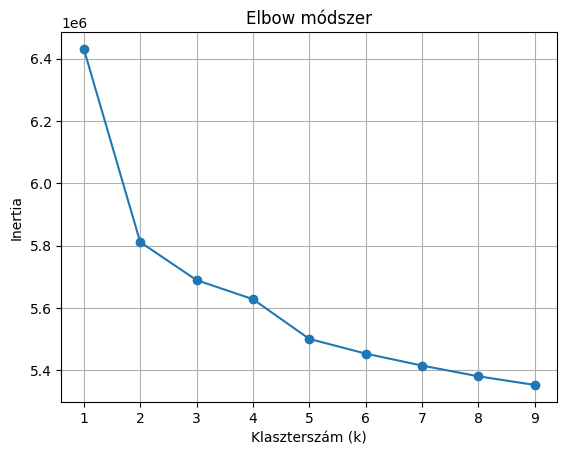

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Skálázás
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optimális klaszterszám keresés (Elbow módszer)
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Klaszterszám (k)')
plt.ylabel('Inertia')
plt.title('Elbow módszer')
plt.grid()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_kmeans = X.copy()
df_kmeans['cluster'] = kmeans.fit_predict(X_scaled)

In [ ]:
# import seaborn as sns

# plt.figure(figsize=(10,6))
# sns.scatterplot(
#     x='avg_home_total_cards',
#     y='total_cards_value',
#     hue='cluster',
#     data=df_kmeans,
#     palette='Set1'
# )
# for team, row in df_kmeans.iterrows():
#     plt.text(row['avg_home_total_cards'] + 0.02, row['total_cards_value'] + 0.02, team, fontsize=8)
# plt.title('Csapatok klaszterezése gólok alapján')
# plt.xlabel('Átlag lőtt gól')
# plt.ylabel('Átlag kapott gól')
# plt.grid(True)
# plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


KeyboardInterrupt: 

In [ ]:
df_dbscan = X.copy()

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.7, min_samples=3)  # eps-t érdemes majd finomhangolni
df_dbscan['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


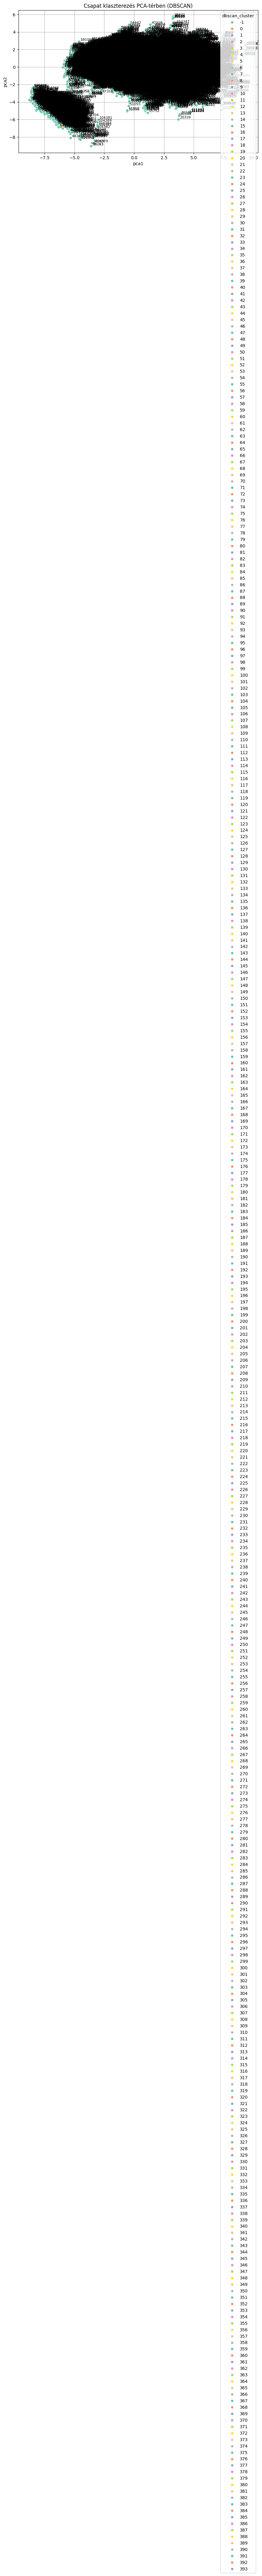

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_dbscan['pca1'] = X_pca[:,0]
df_dbscan['pca2'] = X_pca[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(
    x='pca1',
    y='pca2',
    hue='dbscan_cluster',
    data=df_dbscan,
    palette='Set2'
)
for team, row in df_dbscan.iterrows():
    plt.text(row['pca1'] + 0.1, row['pca2'] + 0.1, team, fontsize=8)
plt.title("Csapat klaszterezés PCA-térben (DBSCAN)")
plt.grid(True)
plt.show()